# Video rendering

In [1]:
import warnings
warnings.filterwarnings("ignore")

from keras.models import load_model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from pylab import rcParams
from tqdm import tqdm

from functions import *
import cv2 

Using TensorFlow backend.


## Load autopilot

In [2]:
model_path = './Models/'

model = load_model(model_path + 'autopilot_500k.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 70, 250, 3)        0         
_________________________________________________________________
convolution2d_1 (Conv2D)     (None, 70, 250, 1)        28        
_________________________________________________________________
maxpooling2d_1 (MaxPooling2D (None, 35, 125, 1)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 125, 1)        0         
_________________________________________________________________
convolution2d_2 (Conv2D)     (None, 35, 125, 2)        20        
_________________________________________________________________
maxpooling2d_2 (MaxPooling2D (None, 17, 62, 2)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 62, 2)         0         
__________

## Load images

In [3]:
img_path = './Datasets/Images4K/'
imgs = load_images(img_path)

print('Image shape = ', np.shape(imgs[0]))

100%|██████████| 2000/2000 [01:10<00:00, 28.33it/s]


6641 Images loaded
Image shape =  (1080, 1920, 3)


Text(0.5,1,'Original image')

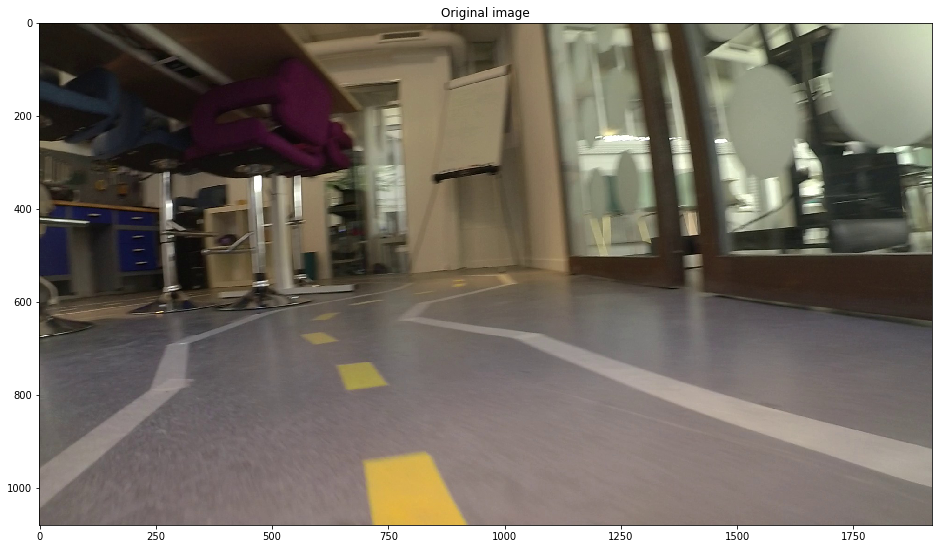

In [4]:
# Set image size
rcParams['figure.figsize'] = 16, 40

plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.title('Original image')

(480, 1800, 3)


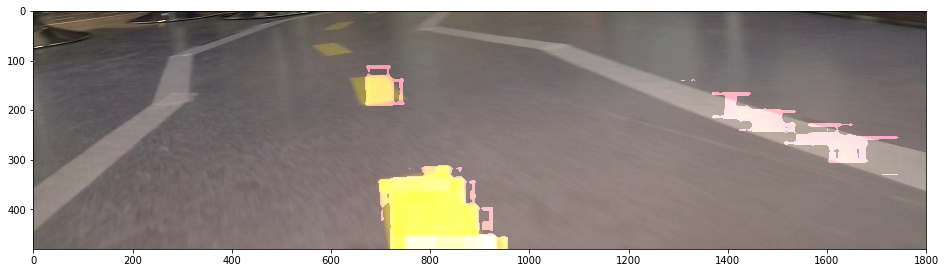

In [5]:
def process(img):
    """Process input image to be feed on the model.
    
    """
    # Crop relevant area
    img = crop(img,600,1080,0,1800)
    # Resize to model's input size
    img = cv2.resize(img,(250,70), interpolation = cv2.INTER_LANCZOS4)#INTER_CUBIC)
    # Smooth image
    kernel = np.ones((2,2),np.float32)/4
    img = cv2.filter2D(img,-1,kernel)

    return img


# Transform original image
cropped_img = crop(imgs[0],600,1080,0,1800)
print(np.shape(cropped_img))
dst = process(imgs[0])

# Get desired inner state (2nd convolutive layer)
layer_name = model.layers[6].name

activations = get_activations(model,np.expand_dims(dst, axis=0), 
                              print_shape_only=True, 
                              layer_name=layer_name)

target_map = norm_pixels(activations[0][0][:,:,1])


def merge(target_map, cropped_img, alpha1=0.35):

    # Get numpy array from matplotlib canvas
    target_map = get_figure(target_map, cmap='inferno').astype('uint8')

    # Crop unnecessary regions
    target_map = crop(target_map,9,63,33,232)

    # Resize to original size
    target_map = cv2.resize(target_map,(1800,480), interpolation = cv2.INTER_CUBIC)

    # Create binary mask
    img2gray = cv2.cvtColor(target_map,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 80, 255, cv2.THRESH_BINARY)

    # Apply mask to activation map
    dst_map = cv2.bitwise_and(target_map, target_map, mask=mask)

    # Convert to BGR (openCV color format)
    color = cv2.cvtColor(dst_map, cv2.COLOR_RGB2BGR)

    # Add images
    final = cv2.add(color,cropped_img)

    return final

# Plot result

dst0 = merge(target_map, cropped_img,0.35)

plt.imshow(cv2.cvtColor(dst0, cv2.COLOR_BGR2RGB))

## Render .AVI video

In [6]:
# Generate merged images
merged_maps = []

layer_name = model.layers[6].name

for i in tqdm(range(0,1999,1)):
    
    # Process input image
    dst = process(imgs[i])

    cropped_img = crop(imgs[i],600,1080,0,1800)
    
    # Get desired activation
    activations = get_activations(model,np.expand_dims(dst, axis=0), 
                                  print_shape_only=True, 
                                  layer_name=layer_name)
    # Normalize target map
    target_map = norm_pixels(activations[0][0][:,:,1])

    # Create merged image and append
    dst = merge(target_map, cropped_img,0.01)
    merged_maps.append(dst)

100%|██████████| 1999/1999 [03:38<00:00,  9.17it/s]


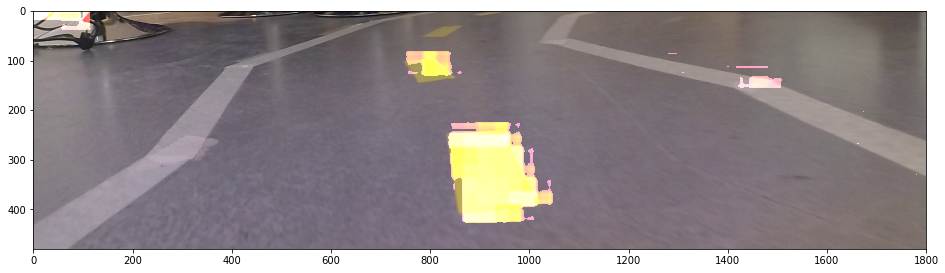

In [31]:
real_sequence(merged_maps,0,15)

In [7]:
# Create video writer
writer = cv2.VideoWriter("sample_output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30,(1800,480))

for frame in tqdm(merged_maps):
    writer.write(frame.astype('uint8'))
    
writer.release()

100%|██████████| 1999/1999 [00:26<00:00, 74.57it/s]
